By [Yulandy Chiu](https://www.youtube.com/@YulandySpace)

Aided with Gemini/Claude/ChatGPT and modified by Yulandy Chiu

Version: 2025/02/08

Videos:
* [Python實作知識蒸餾 Knowledge Distillation | 了解DeepSeek訓練推理語言模型的技術](https://youtu.be/vIIqgQm4ELY)

Facebook: [Yulandy Chiu的AI資訊站](https://www.facebook.com/yulandychiu)

 This code is licensed under the Creative Commons Attribution-NonCommercial 4.0
 International License (CC BY-NC 4.0). You are free to use, modify, and share this code for non-commercial purposes, provided you give appropriate credit. For more details, see the LICENSE file or visit: https://creativecommons.org/licenses/by-nc/4.0/
 © [2025] [Yulandy Chiu](https://www.youtube.com/@YulandySpace)


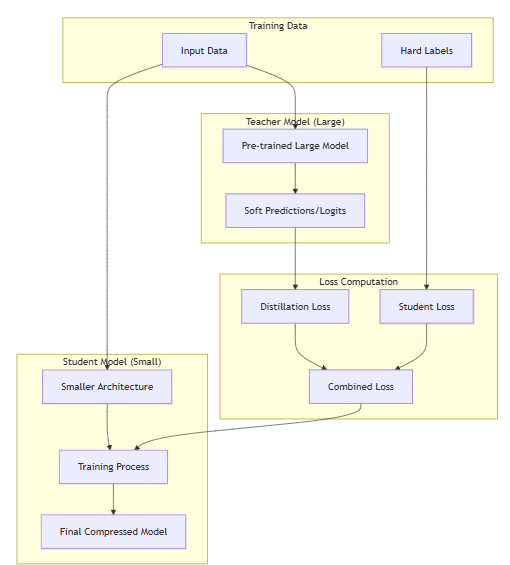

安裝必要套件

In [ ]:
!pip install tensorflow
!pip install pandas
!pip install matplotlib

主程式

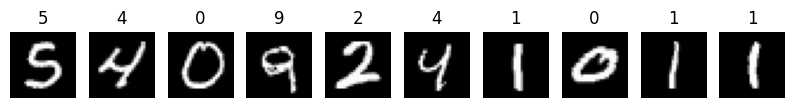

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tensorflow import keras

# 1. 載入 MNIST 數據集並進行標準化，讓數值在[0,1]
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# 隨機選擇一些樣本來視覺化數據
num_samples = 10
indices = random.sample(range(len(x_train)), num_samples)
selected_images = x_train[indices]
selected_labels = y_train[indices]

plt.figure(figsize=(10, 2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(selected_images[i], cmap='gray')
    plt.axis('off')
    plt.title(selected_labels[i])
plt.show()

# 設定Teacher 和 Student Model訓練的 epochs 次數
epochs = 6

In [ ]:
# 2. 定義 Teacher Model（較大型的模型）
# 卷積神經網路 Convolutional Neural Network（CNN）
teacher_model = keras.Sequential([
    keras.layers.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)  # 不使用softmax，因為 SparseCategoricalCrossentropy(from_logits=True) 會自動處理 logits，同時也避免數值溢出 (exp數值趨近無限大)
])

# 擴展維度，使其符合 CNN 的輸入格式
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]


# from_logits=True，在loss自動處理logits，內部直接對 logits 計算交叉熵，不需要額外的Softmax，可避免計算過程中的數值溢出
teacher_model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
print("\nTraining Teacher Model...")
teacher_history = teacher_model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

teacher_results = {
    'epoch': list(range(1, epochs + 1)),
    'train_acc': teacher_history.history['accuracy'],
    'test_acc': teacher_history.history['val_accuracy']
}


Training Teacher Model...
Epoch 1/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9088 - loss: 0.2999 - val_accuracy: 0.9863 - val_loss: 0.0441
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9869 - loss: 0.0434 - val_accuracy: 0.9890 - val_loss: 0.0345
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9907 - loss: 0.0293 - val_accuracy: 0.9918 - val_loss: 0.0247
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9936 - loss: 0.0205 - val_accuracy: 0.9904 - val_loss: 0.0276
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9960 - loss: 0.0134 - val_accuracy: 0.9911 - val_loss: 0.0307
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9968 - loss: 0.0099 - val_accuracy: 0.9921 - val_loss: 0.0251


In [ ]:
# 3. 定義 Student Model（較輕量的模型）
# 多層感知器 Multi-Layer Perceptron（MLP）
student_model = keras.Sequential([
    keras.layers.Input(shape=(28, 28, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10)  # 不使用softmax，因為 SparseCategoricalCrossentropy(from_logits=True) 會自動處理 logits，同時也避免數值溢出 (exp數值趨近無限大)
])

student_model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
print("\nTraining Student Model (Hard Label)...")
student_history = student_model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

student_results = {
    'epoch': list(range(1, epochs + 1)),
    'train_acc': student_history.history['accuracy'],
    'test_acc': student_history.history['val_accuracy']
}


Training Student Model (Hard Label)...
Epoch 1/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8604 - loss: 0.4972 - val_accuracy: 0.9520 - val_loss: 0.1667
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9550 - loss: 0.1554 - val_accuracy: 0.9590 - val_loss: 0.1361
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9677 - loss: 0.1079 - val_accuracy: 0.9685 - val_loss: 0.1030
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9761 - loss: 0.0840 - val_accuracy: 0.9729 - val_loss: 0.0941
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9794 - loss: 0.0677 - val_accuracy: 0.9742 - val_loss: 0.0903
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9832 - loss: 0.0560 - val_accuracy: 0.9739 - val_loss: 0.0862


In [ ]:
# 4. 定義 Knowledge Distillation 訓練過程
class DistillationModel(keras.Model):
    def __init__(self, student, teacher, temperature=5.0, alpha=0.5):
        """
        初始化蒸餾模型

        參數:
        - student: 學生模型
        - teacher: 教師模型
        - temperature: 蒸餾溫度 (T)，用於調整 softmax 平滑度
        - alpha: 平衡因子，控制硬標籤與軟標籤的比例
        """
        super(DistillationModel, self).__init__()
        self.student = student
        self.teacher = teacher
        self.temperature = temperature
        self.alpha = alpha
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.accuracy_tracker = keras.metrics.SparseCategoricalAccuracy(name="accuracy")

    def compile(self, optimizer, loss_fn):
        """
        設定優化器與損失函數

        參數:
        - optimizer: 優化器，例如 Adam
        - loss_fn: 損失函數，例如 SparseCategoricalCrossentropy(from_logits=True)
        """
        super(DistillationModel, self).compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn

    def call(self, inputs, training=False):
        """
        執行前向傳播 (forward pass)

        參數:
        - inputs: 輸入數據
        - training: 是否為訓練模式

        回傳:
        - 學生模型的預測結果
        """
        return self.student(inputs, training=training)

    def train_step(self, data):
        """
        訓練步驟 (Training Step)

        1. 使用教師模型預測 logits (未經 softmax)
        2. 使用學生模型進行前向傳播，獲取學生 logits
        3. 計算硬標籤交叉熵損失
        4. 計算軟標籤 Kullback-Leibler 散度 (KL 散度)
        5. 總損失 = α * 硬標籤損失 + (1 - α) * 軟標籤蒸餾損失
        6. 執行梯度下降並更新學生模型權重
        """
        x, y = data

        # 獲取教師模型的 logits（未經 softmax 的分數）
        teacher_pred = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # 獲取學生模型的 logits（未經 softmax 的分數）
            student_pred = self.student(x, training=True)

            # 計算硬標籤交叉熵損失
            hard_loss = self.loss_fn(y, student_pred)

            # 轉換為機率分佈 (使用溫度調整)
            soft_teacher = tf.nn.softmax(teacher_pred / self.temperature)
            soft_student = tf.nn.softmax(student_pred / self.temperature)

            # 計算 Kullback-Leibler 散度作為蒸餾損失
            distill_loss = keras.losses.KLDivergence()(soft_teacher, soft_student)

            # 總損失 = α * 硬標籤損失 + (1 - α) * 蒸餾損失
            loss = self.alpha * hard_loss + (1 - self.alpha) * distill_loss

        # 計算梯度並更新學生模型參數
        grads = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))

        # 更新指標
        self.loss_tracker.update_state(loss)
        self.accuracy_tracker.update_state(y, student_pred)

        return {"loss": self.loss_tracker.result(), "accuracy": self.accuracy_tracker.result()}

    def test_step(self, data):
        """
        測試步驟 (Test Step)

        1. 使用學生模型進行預測
        2. 計算硬標籤交叉熵損失
        3. 更新測試時的準確度指標
        """
        x, y = data
        student_pred = self.student(x, training=False)
        loss = self.loss_fn(y, student_pred)

        # 更新指標
        self.loss_tracker.update_state(loss)
        self.accuracy_tracker.update_state(y, student_pred)

        return {"loss": self.loss_tracker.result(), "accuracy": self.accuracy_tracker.result()}


In [ ]:
# 5. 訓練 Student Model (Knowledge Distillation)
distilled_student = DistillationModel(student=student_model, teacher=teacher_model)
distilled_student.compile(optimizer=keras.optimizers.Adam(), loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

print("\nTraining Student Model (Knowledge Distillation)...")
distilled_history = distilled_student.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))


Training Student Model (Knowledge Distillation)...
Epoch 1/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9827 - loss: 0.0852 - val_accuracy: 0.9762 - val_loss: 0.0886
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9864 - loss: 0.0658 - val_accuracy: 0.9757 - val_loss: 0.0939
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9881 - loss: 0.0592 - val_accuracy: 0.9787 - val_loss: 0.0843
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9906 - loss: 0.0534 - val_accuracy: 0.9786 - val_loss: 0.0832
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9918 - loss: 0.0485 - val_accuracy: 0.9772 - val_loss: 0.0866
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9927 - loss: 0.0458 - val_accuracy: 0.9791 - val_loss: 0.0832



Training Results:
   Epoch  Teacher_Train_Acc  Teacher_Test_Acc  Student_Hard_Train_Acc  Student_Hard_Test_Acc  Student_Distill_Train_Acc  Student_Distill_Test_Acc
0      1             0.9595            0.9863                  0.9144                 0.9520                     0.9817                    0.9762
1      2             0.9869            0.9890                  0.9582                 0.9590                     0.9855                    0.9757
2      3             0.9906            0.9918                  0.9686                 0.9685                     0.9877                    0.9787
3      4             0.9932            0.9904                  0.9748                 0.9729                     0.9895                    0.9786
4      5             0.9949            0.9911                  0.9793                 0.9742                     0.9904                    0.9772
5      6             0.9961            0.9921                  0.9821                 0.9739             

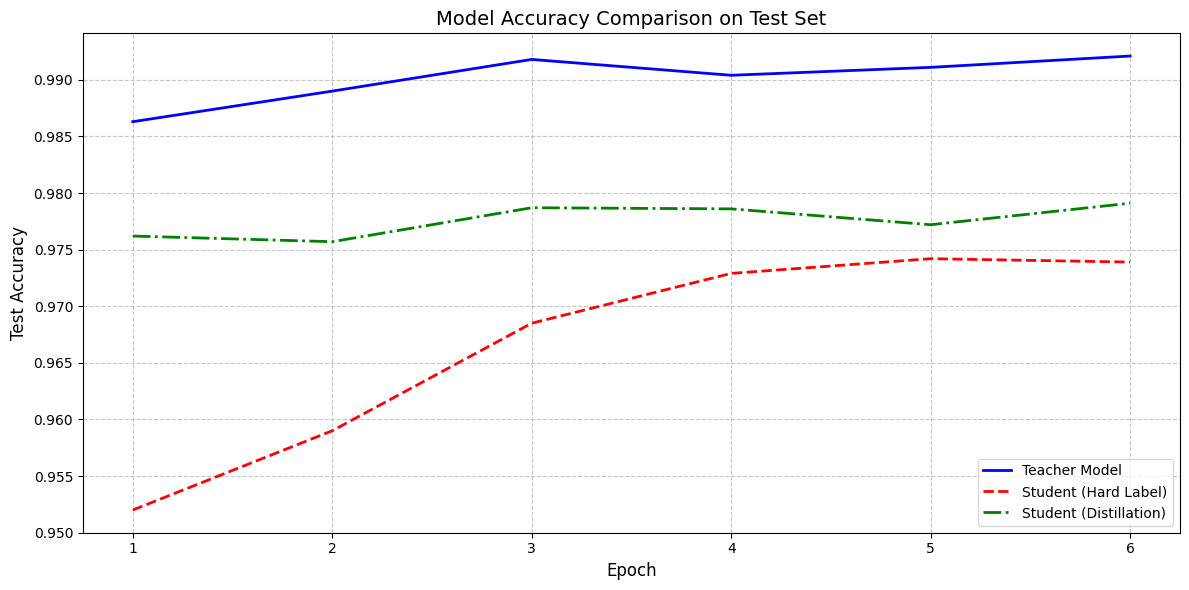

In [ ]:
# 6. 顯示訓練結果並保存到 CSV
results_df = pd.DataFrame({
    'Epoch': list(range(1, epochs + 1)),
    'Teacher_Train_Acc': teacher_results['train_acc'],
    'Teacher_Test_Acc': teacher_results['test_acc'],
    'Student_Hard_Train_Acc': student_results['train_acc'],
    'Student_Hard_Test_Acc': student_results['test_acc'],
    'Student_Distill_Train_Acc': distilled_history.history['accuracy'],
    'Student_Distill_Test_Acc': distilled_history.history['val_accuracy']
})

print("\nTraining Results:")
print(results_df.to_string(float_format=lambda x: '{:.4f}'.format(x)))

results_df.to_csv('training_results.csv', index=False)
print("\nResults have been saved to 'training_results.csv'")
# 繪製圖表
plt.figure(figsize=(12, 6))
plt.plot(results_df['Epoch'], results_df['Teacher_Test_Acc'], 'b-', label='Teacher Model', linewidth=2)
plt.plot(results_df['Epoch'], results_df['Student_Hard_Test_Acc'], 'r--', label='Student (Hard Label)', linewidth=2)
plt.plot(results_df['Epoch'], results_df['Student_Distill_Test_Acc'], 'g-.', label='Student (Distillation)', linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Model Accuracy Comparison on Test Set', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()

# 保存圖片
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 學習方式
# Student (Hard Label): 讓學生模型的預測與真實標籤 (y_train) 一致
# Student (Distillation): 讓學生模型的預測與真實標籤一致，還讓它的預測機率分布接近教師模型
## 蒸餾的優勢
# 蒸餾的作用不只是加速學習，而是提升學習質量
# 蒸餾能讓 Student Model 學到更多「類別之間的關係」，提升泛化能力
# Hard Label 學習方式可以透過增加 epochs 來逼近蒸餾，但不一定能完全達到蒸餾的效果，並且需要更多訓練時間
## 蒸餾對學生模型的效能影響
# 大部分情況下：Student Model 主要是讓效能快速趨近 Teacher Model，但不太可能超越 Teacher Model，因為它的目標是學習老師的知識，而不是創造新的知識。
# 特殊情況下: Student 可能超越 Teacher
# * Teacher Model 過擬合，而 Student Model 泛化更好
# * Teacher Model 設計或訓練不佳，Student Model 避免了這些問題
# * Student Model 學習了多個 Teacher Models 的知識
# * Student Model 透過額外數據進行微調